In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

### Load images

In [2]:
# Lets read the train data and the train labels. 
train_data_directory = 'D:/Brain_Tumor_Data/train'
data_directory = 'D:/Brain_Tumor_Data'
IMAGE_SIZE = 128
NUM_IMAGES = 64
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="FLAIR", split="test", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

(1, 128, 128, 64)
0.0 1.0 0.06278081447195914 0.00016408131415728857
Dimension of the CT scan is: (128, 128, 64)


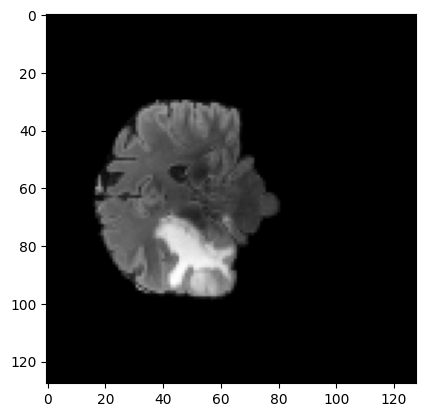

In [3]:
a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

In [4]:
df_train_labels = pd.read_csv('D:/Brain_Tumor_Data/_labels.csv')
df_train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [5]:
train_data_directory = 'D:/Brain_Tumor_Data/train'
print(min(os.listdir(train_data_directory)), max(os.listdir(train_data_directory)))

00000 01010


In [6]:
total_training_scans = np.array([load_dicom_images_3d(a, split = 'train') for a in os.listdir(train_data_directory)])

In [7]:
len(total_training_scans)

585

(585, 1, 128, 128, 64)
585
Dimension of the CT scan is: (1, 128, 128, 64)


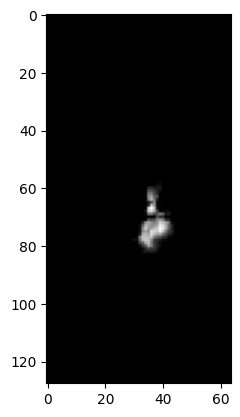

In [8]:
print(total_training_scans.shape)
print(len(total_training_scans))
image = total_training_scans[20]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 25]), cmap="gray")

In [9]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.array([train.T for train in total_training_scans[:410]])
x_val = np.array([train.T for train in total_training_scans[410:]])

In [10]:
x_train.shape

(410, 64, 128, 128, 1)

In [11]:
x_train = x_train[:410]

In [12]:
x_train.shape

(410, 64, 128, 128, 1)

In [13]:
total_training_labels = df_train_labels["MGMT_value"].to_list()

In [14]:
total_training_labels = total_training_labels[:585]

In [15]:
len(total_training_labels)

585

In [16]:
y_train = total_training_labels[:410]
y_val = total_training_labels[410:]

(1, 128, 128, 64)
0.0 1.0 0.06278081447195914 0.00016408131415728857
Dimension of the CT scan is: (128, 128, 64)


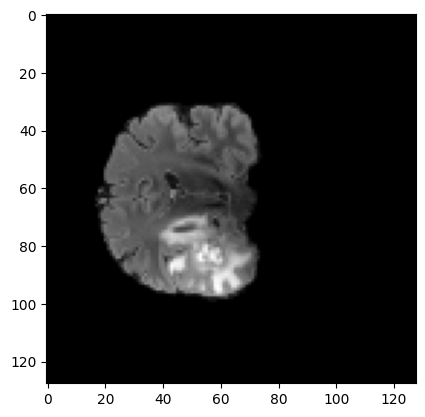

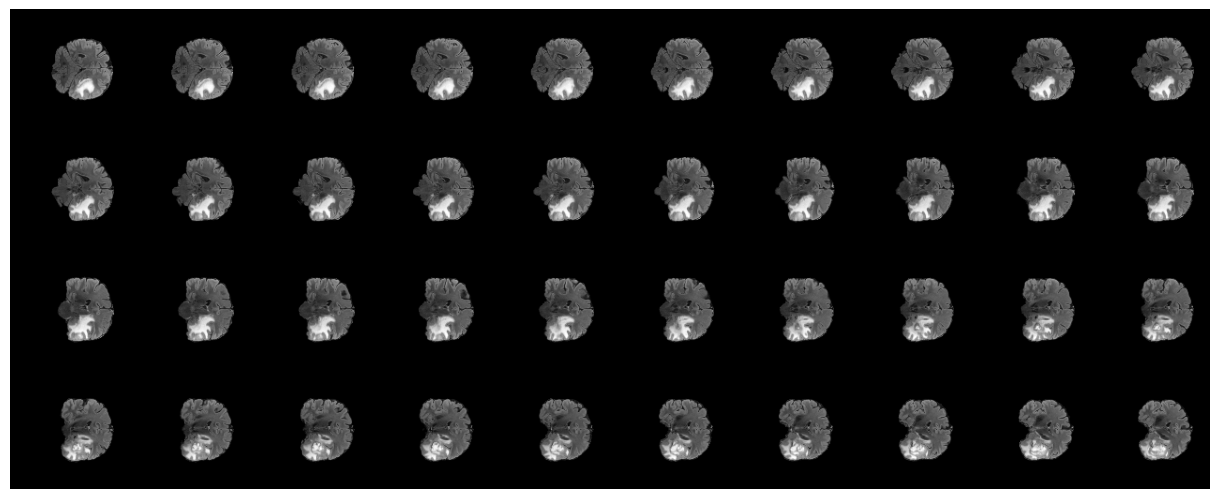

In [17]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
plot_slices(4, 10, 128, 128, image[:, :, :40])

### Model

In [18]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,width, height,1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 128, 128, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 62, 126, 126, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 31, 63, 63, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 63, 63, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 29, 61, 61, 64)    110656    
                                                             

In [19]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_MoreData.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
history = model.fit(
    tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4),
    validation_data=tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(4),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
103/103 - 21s - loss: 0.7248 - acc: 0.5195 - val_loss: 0.7228 - val_acc: 0.4343 - 21s/epoch - 199ms/step
Epoch 2/10
103/103 - 15s - loss: 0.6986 - acc: 0.5537 - val_loss: 0.8067 - val_acc: 0.4343 - 15s/epoch - 143ms/step
Epoch 3/10
103/103 - 14s - loss: 0.6793 - acc: 0.5756 - val_loss: 0.8064 - val_acc: 0.4400 - 14s/epoch - 138ms/step
Epoch 4/10
103/103 - 15s - loss: 0.6598 - acc: 0.6268 - val_loss: 0.9327 - val_acc: 0.4400 - 15s/epoch - 144ms/step
Epoch 5/10
103/103 - 15s - loss: 0.6541 - acc: 0.6317 - val_loss: 0.8159 - val_acc: 0.4514 - 15s/epoch - 142ms/step
Epoch 6/10
103/103 - 15s - loss: 0.6305 - acc: 0.6439 - val_loss: 0.7585 - val_acc: 0.4971 - 15s/epoch - 142ms/step
Epoch 7/10
103/103 - 15s - loss: 0.6034 - acc: 0.6854 - val_loss: 0.8575 - val_acc: 0.5371 - 15s/epoch - 145ms/step
Epoch 8/10
103/103 - 15s - loss: 0.5836 - acc: 0.6902 - val_loss: 0.9284 - val_acc: 0.5200 - 15s/epoch - 145ms/step
Epoch 9/10
103/103 - 15s - loss: 0.5692 - acc: 0.7024 - val_loss: 0.9166

### Plot Model Statistics

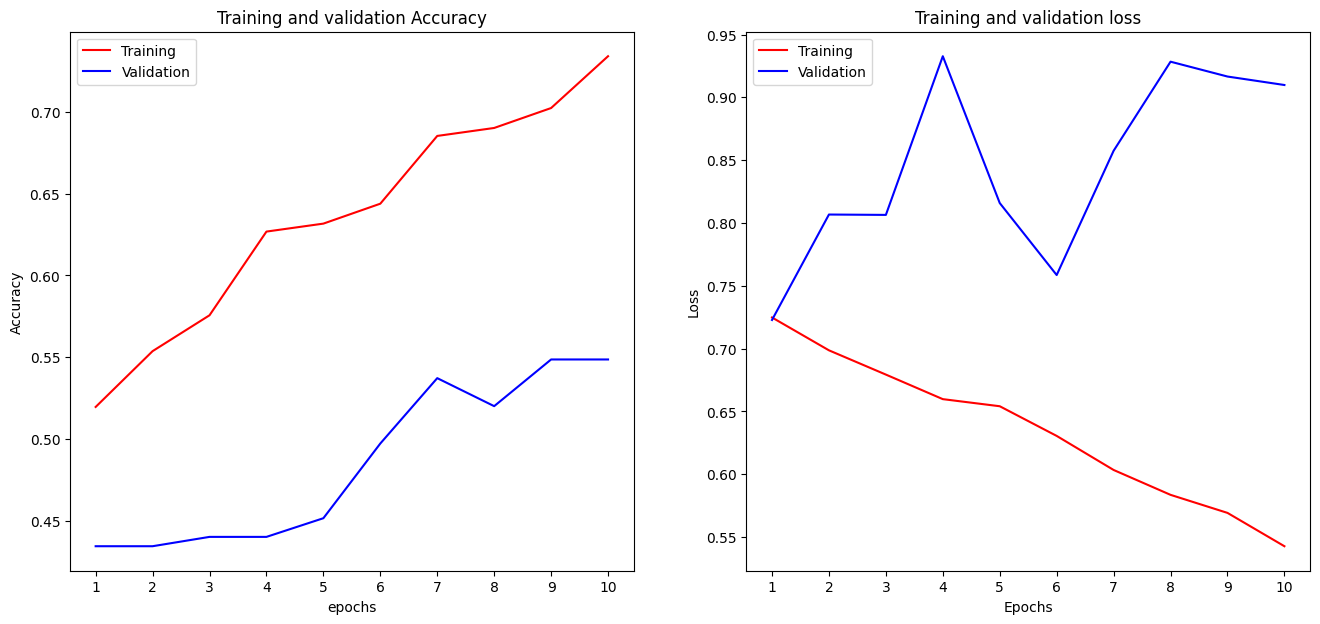

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1) # Get number of epochs
ax1 = plt.subplot(1,2,1)
ax1.plot(epochs, acc, 'r')
ax1.plot(epochs, val_acc, 'b')
ax1.set_xticks([i for i in epochs])
ax1.set_title('Training and validation Accuracy')
ax1.legend(["Training", "Validation" ])
ax1.set_xlabel("epochs")
ax1.set_ylabel("Accuracy")

ax2 = plt.subplot(1,2,2)
ax2.plot(epochs, loss, 'r')
ax2.plot(epochs, val_loss, 'b')
ax2.set_xticks([i for i in epochs])
ax2.legend(["Training", "Validation" ])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title('Training and validation loss')

plt.show()